# GDAL Rasters

For spatial data, the amazing workhorse is GDAL (I realize now I use the word workhorse waaaaaay way too much). You might have heard of this in the R context from RGDAL. The open-source scientific computing stack is all interlinked. Under the hood, just like with Numpy, GDAL is implemented in very fast C-based code. The python bindings are just a way to access that code from python.

## Spatial data in Jupyter

First we're going to import gdal, numpy and a few other things.

In [ ]:
from osgeo import gdal
import numpy as np
import os, random

First, define the path to our raster data. This is remarkably difficult (at least, as measured by how many hours I have wasted because my code pointed to the wrong place). A the superior way to manage this is with RELATIVE PATHS. Here, we define the filename, the directory in relative terms, and then join them together using the os functions.

In [ ]:
geotiff_filename = 'maize_Production.tif'

# the ../ notation means go up one level relative to your current working directory. This gets us outside of the course
# repository and into our Data directory
data_directory = '../../base_data' 

# Join them together (this will work across operating systems)
geotiff_file_path = os.path.join(data_directory, geotiff_filename)

print('geotiff_file_path', geotiff_file_path)

geotiff_file_path ../../base_data/maize_Production.tif


It's easy to get confused by relative paths, accidentally missing a level or something. In my experience (and looking at what questions we've had come up so far in class), the majority of code errors come from pointing to a "path" that does not exist on your harddrive.

Relative filepaths are defined relative to the current working directory (CWD). One way to trouble-shoot missing paths, then, is to view the current working direcotry:

In [ ]:
print(os.getcwd())

/Users/etoiletang/Dropbox/Mac/Downloads/Apec8222/apec_8222_2025_Zihan/python_basics


Or to view the absolute path:

In [ ]:
os.path.abspath(data_directory)

'/Users/etoiletang/Dropbox/Mac/Downloads/Apec8222/base_data'

Sometimes it can be useful to see what is in the directory you've specified (to help you figure out what's going on if it can't find the file)

In [ ]:
contents = os.listdir(data_directory)
print(contents)

['.DS_Store', 'cartographic', 'maize_Production.tif']


In [ ]:
# If you want to be super clear, you can actually check if it exists
print(os.path.exists(geotiff_file_path))

True


## GDAL and opening the raster

Now that we know for sure that the file is there, we can use gdal and it's Open function using the DOT notation (technically its a "method" not a function, but you can ignore that. If you're actually curious about object-oriented programming, a method is just a function attached to an object.).

In [ ]:
maize_production_tons_per_cell = gdal.Open(geotiff_file_path)
print(maize_production_tons_per_cell)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1065f8240> >


The dataset object holds information about the area and extent of the data, or the geotransform information

In [ ]:
geotransform = maize_production_tons_per_cell.GetGeoTransform()
projection = maize_production_tons_per_cell.GetProjection()

print('GDAL dataset geotransform', geotransform)
print('GDAL dataset projection', projection)

GDAL dataset geotransform (-180.0, 0.0833333333333286, 0.0, 89.99999999998977, 0.0, -0.0833333333333286)
GDAL dataset projection GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


IMPORTANT ANNOYING NOTE: in programming, there are different conventions for identifying a place by rows, cols vs. x, y vs. upper-left, lower-right, etc. Numpy is denoted row, col but gdal is denoted X, Y (which flips the order). Just memorize that row = Y and col = X.

In [ ]:
n_rows = maize_production_tons_per_cell.RasterYSize
print('Number of rows in a GDAL dataset', n_rows)

n_cols = maize_production_tons_per_cell.RasterXSize
print('Number of columns in a GDAL dataset', n_cols)

Number of rows in a GDAL dataset 2160
Number of columns in a GDAL dataset 4320


Next, get the "band" of the dataset. Many datasets have multiple layers (e.g. NetCDFs). Geotiffs can have multiple bands but often have just 1. For now, grab band 1

In [ ]:
maize_production_tons_per_cell_band = maize_production_tons_per_cell.GetRasterBand(1)

The band object has information too, like the datatype of the geotiff:

In [ ]:
data_type = maize_production_tons_per_cell_band.DataType
no_data_value = maize_production_tons_per_cell_band.GetNoDataValue()

print('data_type', data_type)
print('no_data_value', no_data_value)

data_type 6
no_data_value -9999.0


Finally, we can get the array from the band as a numpy array:

In [ ]:
array = maize_production_tons_per_cell_band.ReadAsArray()
shape = array.shape

print('Look at the array itself', array)

Look at the array itself [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


## Plotting a raster

We are now going to use matplotlib. It is basically like ggplot and draws its inspiration from MATLAB notation. By convention, we'll import it into the variable name plt, which is an object that lets us use matplotlib plotting notation.

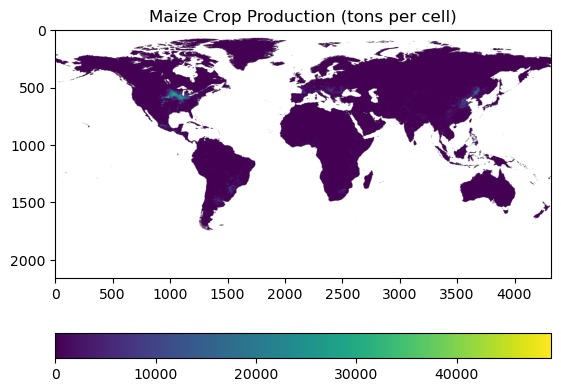

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(array)
plt.title('Maize Crop Production (tons per cell)')
plt.colorbar(orientation='horizontal')

# Uncomment this if you want to save it
# plt.savefig('maize.png', dpi=300) 

plt.show()

This is super ugly for one primary reason: it has scaled the colorbar to the minimum and maximum values, which ends up coloring nearly everything close to the zero value. We're going to crop the values it shoes to not let the outliers define the colorbar range.

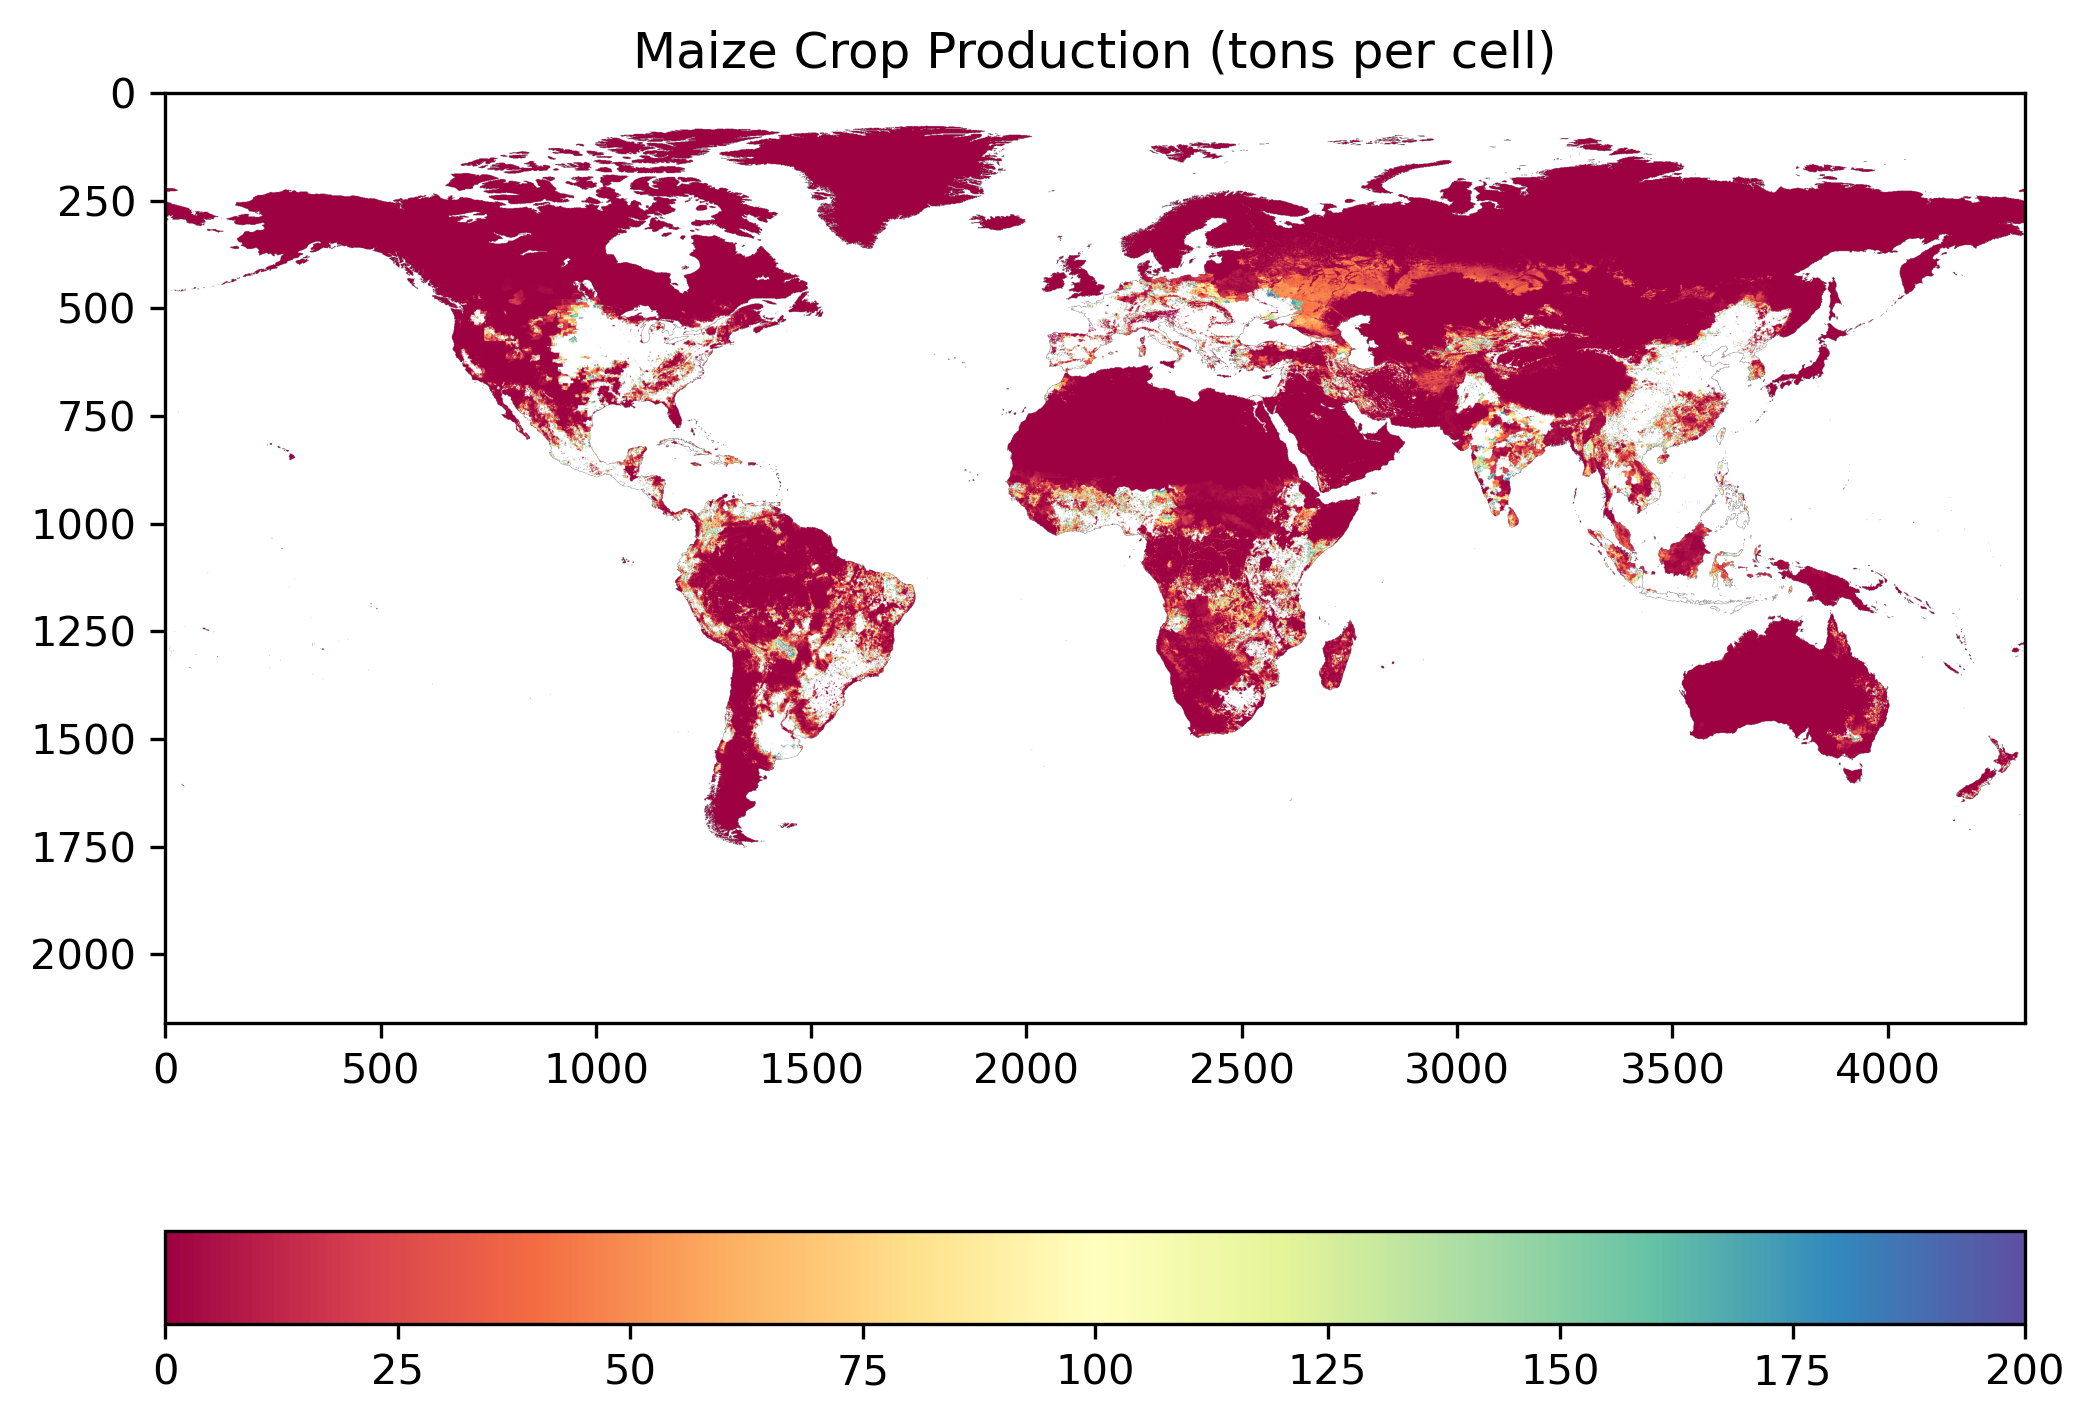

In [ ]:
import matplotlib.pyplot as plt

# The second (and often better) plotting method is to use plt to create a figure and one ore more axes.
# This is potentially confusing but is powerful. the Axes object we created (ax) is the plottable area (and there could be lots of axes)
# The figure contains all the axes and is responsible for organizing stuff.

fig = plt.figure(figsize=(8, 6))
fig.set_dpi(300)

ax = fig.add_subplot()

# Set the title of this ax object
ax.set_title('Maize Crop Production (tons per cell)')

# Using the ax we created, we call the imshow function on our array from earlier. This create a new "im" object
im = ax.imshow(array)

# To fix the outlier problem from before, we use the im object to set its limits.
im.set_clim(0, 200)

# Set the cbar to spectral
im.set_cmap('Spectral')

# Get the cmap
cmap = im.get_cmap()
cmap.set_over('white', alpha=1.0)


# Add the colorbar to the figure. It will generate its values from the im object.
fig.colorbar(im, orientation='horizontal')

plt.show()

## Copies versus Views in Numpy

Part of how Numpy arrays are fast is the only ever load or access data when it is needed. This means that if you don't tell numpy to make a copy of something, any new variable will point to the old array. More specifically, this only creates a new pointer to the same block of memory on your computer that holds the array. If we change c_view, c will also be changed. So in the below, c_view only points to the old data in c. This is called a "view" of the array.

In [ ]:
c_view = array

This also means that if you modify array, you will be modifying what you have in c_view.

If you really need a copy in memory, you can use the numpy method copy():

In [ ]:
d = array.copy()

This gives us a NEW array in a new block of memory, so changing array will not change d,

## In-class exercise 4.1

Here you will use GDAL and numpy to do some highly-optimized raster manipulation.

Using data from Earthstat, I want you to calculate the production per grid-cell of Maize, globally, at "high"-resolution.

The two files you need are in your class data directory (obtained from google drive) named as follows.

```         
maize_HarvestedAreaHectares.tif
maize_YieldPerHectare.tif
```

Use the os.path.join() approach from earlier to correcly make relative paths pointing to the two files.

Open them up as raster using Gdal.

Multiply the HarvestedAreaHectars by YieldPerHectare. This will give you the total production on the grid-cell.

Use numpy to sum up the total production of Maize globally and report that to the class.

# Saving a raster to your harddrive

Now that you've created an amazing raster of total maize production, you might want to save it to your harddrive.

To do this, we're first going to define a new filename for our output file. In the code below, + concatenates things. Str() makes the number a string.

In [ ]:
Exercise_filename1 = 'maize_HarvestedAreaHectares.tif'
Exercise_filename2 = 'maize_YieldPerHectare.tif'

# the ../ notation means go up one level relative to your current working directory. This gets us outside of the course
# repository and into our Data directory
data_directory = '../../base_data' 

# Join them together (this will work across operating systems)
exercise_file_path1 = os.path.join(data_directory, Exercise_filename1)
exercise_file_path2 = os.path.join(data_directory, Exercise_filename2)


print(os.path.exists(exercise_file_path1))
print(os.path.exists(exercise_file_path2))

## Open files
harvested_area = gdal.Open(exercise_file_path1)
yield_per_hectare = gdal.Open(exercise_file_path2)
print(harvested_area)

True
True
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10a952160> >


In [ ]:
output_filename = 'gdal_created_array_' + str(random.randint(1, 1000000)) + '.tif'
output_file_path = os.path.join(data_directory, output_filename)

Create a new file at that filename location using the attributes we used above. Notice that we flipped n_cols and n_rows from how numpy would have wanted it. For extra BONUS value, replace the d array with the one you created in the in-class exercise.

In [ ]:
output_dataset = gdal.GetDriverByName('GTiff').Create(output_file_path, d.shape[1], d.shape[0], 1, 6)

Set dataset-level information. Here we're just using what we got from the input raster, defined above.

In [ ]:
output_dataset.SetGeoTransform(geotransform)
output_dataset.SetProjection(projection)

Now get a band from our new dataset on which we'll write our array.

In [ ]:
output_band = output_dataset.GetRasterBand(1)

Do the array writing

In [ ]:
output_band.WriteArray(d)

Set any final band-level information

In [ ]:
output_band.SetNoDataValue(no_data_value)

Finally, and very importantly, clean up after yourself. It wont actually write until the resources in memory have been released.

In [ ]:
d = None
output_band = None
output_dataset = None